In [2]:
#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, PolynomialFeatures
import lightgbm as lgb
import mmap
import shutil
import contextlib

In [52]:
df = pd.read_csv('exported_features/all_features_imdb.csv', index_col=False)
X = df.drop(["revenue"], axis=1)
X['popu'] = (X['numRatings']/X[rating''])
X['budgetRating'] = X['budgetlog'] * X['popu']
Y = df.revenue
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

In [23]:
lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.01,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.9,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [53]:
fit_params={"early_stopping_rounds": 500, "verbose": 100, "eval_metric": "rmse"}
lgbmodel.fit(X_train, np.log1p(y_train), eval_set=[(X_test, np.log1p(y_test))], **fit_params)

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.01315
[200]	valid_0's rmse: 1.81431
[300]	valid_0's rmse: 1.7676
[400]	valid_0's rmse: 1.7594
[500]	valid_0's rmse: 1.76003
[600]	valid_0's rmse: 1.76294
[700]	valid_0's rmse: 1.76952
[800]	valid_0's rmse: 1.77002
Early stopping, best iteration is:
[387]	valid_0's rmse: 1.75837


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, boosting='gbdt',
       boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       feature_fraction=0.9, importance_type='gain', lambda_l1=0.2,
       learning_rate=0.01, max_depth=5, metric='rmse',
       min_child_samples=100, min_child_weight=0.001, min_data_in_leaf=10,
       min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=30,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0, use_best_model=True)

In [55]:
predictions = lgbmodel.predict(X_test)
predictions[predictions < 0] = 0
print("error: ", mean_squared_error(np.log1p(y_test), predictions)**0.5)

error:  1.7583683943271906


In [71]:
difference = np.abs(np.log1p(y_test) - predictions)
X_diff = X_test.merge(difference.to_frame(), left_index=True, right_index=True)
X_diff = X_diff.merge(y_test.to_frame(), left_index=True, right_index=True)
display(X_diff.sort_values(by=['revenue_x'], ascending=False)[0:20])
#print(X_diff.loc[1190])
#originalData.loc[1191]

,Unnamed: 0,id,budgetlog,normalizedBudgetLog,popularitylog,budgetPop,runtime,Age,hasStar,NumStar,...,Fantasy,Horror,Animation,numberGenres,rating,numRatings,popu,budgetRating,revenue_x,revenue_y
2433,2433,2434,15.894952,0.248754,2.298882,36.540619,87.0,21,1,1,...,False,False,False,1.0,6.3,33818,5367.936508,85323.094339,12.685554,32
2582,2582,2583,15.894952,0.220184,1.370960,21.791338,90.0,14,0,0,...,False,False,False,2.0,6.7,17927,2675.671642,42529.672915,11.637988,8
2759,2759,2760,15.894952,0.279442,0.081322,1.292608,98.0,22,0,0,...,False,False,False,3.0,5.1,125,24.509804,389.582162,9.632350,13
2864,2864,2865,12.923915,0.130801,0.570444,7.372375,101.0,45,0,0,...,False,False,False,2.0,6.7,1256,187.462687,2422.751804,9.397118,100
2874,2874,2875,15.894952,0.274070,1.152495,18.318846,89.0,7,0,0,...,False,False,False,2.0,6.3,1630,258.730159,4112.503512,8.330665,25
2474,2474,2475,15.894952,0.237891,1.041252,16.550654,116.0,4,0,0,...,False,False,False,3.0,3.0,2018,672.666667,10692.004530,8.206412,79
2645,2645,2646,15.894952,0.266715,0.408128,6.487179,104.0,3,0,0,...,False,False,False,1.0,5.6,325,58.035714,922.474906,6.641919,76000000
2577,2577,2578,15.894952,0.693147,0.189952,3.019271,11.0,89,0,0,...,False,False,False,2.0,7.2,1018,141.388889,2247.369634,6.469247,97
2963,2963,2964,15.894952,0.245140,0.999984,15.894690,129.0,10,0,0,...,False,False,False,2.0,7.1,2604,366.760563,5829.641633,6.114680,44038000
2405,2405,2406,14.731802,0.079825,1.866507,27.497006,102.0,5,1,3,...,False,False,False,1.0,4.8,9155,1907.291667,28097.842598,5.667997,3003


In [57]:
originalData = pd.read_csv('data/train.csv', index_col='id')
#originalData[np.abs(X_diff.revenue_x)>5]
rowsWithLargeGap = X_diff.index[(np.abs(X_diff.revenue_x)>5) & (np.abs(X_diff.revenue_x)<20)] + 1
print()
originalData.loc[rowsWithLargeGap ]

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2406,NaN,2500000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt1945062,en,About Cherry,A drama centered on a troubled young woman who...,5.465670,/8m4cU75IzvsQQ7QovMm3k0VCkoJ.jpg,...,2/14/12,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,There's No Such Thing As Going Too Far.,About Cherry,"[{'id': 445, 'name': 'pornography'}]","[{'cast_id': 1, 'character': 'Angelina', 'cred...","[{'credit_id': '5645399cc3a36870e0007253', 'de...",3003
2434,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0115697,en,Black Sheep,When dignified Albert Donnelly runs for Govern...,8.963037,/2wsaboVhKXpsLchoaXi0oWmQ7xM.jpg,...,2/1/96,87.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,There's one in every family.,Black Sheep,"[{'id': 169078, 'name': 'nitrous oxide'}, {'id...","[{'cast_id': 1, 'character': 'Mike Donnelly', ...","[{'credit_id': '52fe45c09251416c75061479', 'de...",32
2475,"[{'id': 212123, 'name': 'Tiny Times Collection...",0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,tt3043630,zh,小时代,When four best friends try and move forward in...,1.832762,/8iF40WZSrGgo716zUMENN6YAI7d.jpg,...,6/27/13,116.0,"[{'iso_639_1': 'zh', 'name': '普通话'}]",Released,NaN,Tiny Times,"[{'id': 2682, 'name': 'shanghai'}]","[{'cast_id': 10, 'character': 'Lin Xiao', 'cre...","[{'credit_id': '52fe4d5ac3a368484e1e482b', 'de...",79
2578,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0131461,en,"The Life and Death of 9413, a Hollywood Extra",This short experimental film tells the story o...,0.209191,/qucO44CRNvKrVYuUurgIJ05A5G9.jpg,...,6/16/28,11.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,"The Life and Death of 9413, a Hollywood Extra","[{'id': 8201, 'name': 'satire'}, {'id': 154802...","[{'cast_id': 2, 'character': '9413', 'credit_i...","[{'credit_id': '5538d20192514112560055d3', 'de...",97
2583,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0339230,sv,Kopps,"A small Swedish village, H√∂gbotr√§sk, is so p...",2.939129,/ng7URIidhDeMKXXTwPb7l9uIvH2.jpg,...,2/6/03,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kops,"[{'id': 5543, 'name': 'cow'}, {'id': 7490, 'na...","[{'cast_id': 1, 'character': 'Jacob', 'credit_...","[{'credit_id': '52fe44ddc3a36847f80ae983', 'de...",8
2646,NaN,0,"[{'id': 10749, 'name': 'Romance'}]",NaN,tt3956312,en,同桌的妳,"In the summer of 1993, timid and shy Zhou Xiao...",0.504000,/7fC54GSyr8KyZ5FimoOqP82JpMn.jpg,...,4/25/14,0.0,"[{'iso_639_1': 'zh', 'name': '普通话'}]",Released,NaN,My Old Classmate,NaN,"[{'cast_id': 0, 'character': 'Zhou Xiao Zhi', ...","[{'credit_id': '54064dd90e0a2658d800d8d9', 'de...",76000000
2760,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0112909,en,Dou Sing 2 - Gai Tau Dou Sing,Lui is the tyrant of gamblers in Macau. He put...,0.084720,/7Z6rSAOhYDBdVpn87zBUJCXDMzg.jpg,...,6/28/95,98.0,"[{'iso_639_1': 'cn', 'name': '广州话 / 廣州話'}]",Released,NaN,The Saint of Gamblers,"[{'id': 395, 'name': 'gambling'}]","[{'cast_id': 3, 'character': 'God Bless You', ...","[{'credit_id': '52fe48bf9251416c750b1f75', 'de...",13
2865,NaN,410000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.wim-wenders.com/movies/movies_spec/...,tt0066773,de,Die Angst des Tormanns beim Elfmeter,The Goalie's Anxiety at the Penalty Kick is a ...,0.769053,/9KicBiKkg6h8dyKM4BBeD3Jy9nt.jpg,...,2/19/72,101.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,The Goalie's Anxiety at the Penalty Kick,"[{'id': 6075, 'name': 'sport'}]","[{'cast_id': 4, 'character': 'Josef Bloch', 'c...","[{'credit_id': '5925158bc3a3687870008efc', 'de...",100
2875,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.edwardburns.net/,tt1619037,en,Nice Guy Johnny,"Johnny Rizzo, is about to trade his dream job ...",2.166081,/zh7fiXWie2VAE7PQDyos4eKON5O.jpg,

Unnamed: 0  -  0.006188810403455671
id  -  0.0004919634676594668
budgetlog  -  0.18687595668679613
normalizedBudgetLog  -  0.11485246707892027
popularitylog  -  0.00866923624920453
budgetPop  -  0.032815762414293306
runtime  -  0.02302756894251734
Age  -  0.04635343760243534
hasStar  -  0.0008545221447918694
NumStar  -  0.001229448659040311
hashomepage  -  0.0016013327577818113
isinCollection  -  0.0073203105805405184
Action  -  0.0014756349625527126
Family  -  0.00620136469447071
Adventure  -  0.002206417702579449
History  -  0.0001907476097412692
Drama  -  0.005888336479959683
Science Fiction  -  0.0020202707339075344
Romance  -  0.002057174339487113
Fantasy  -  0.0006057991084182415
Horror  -  0.0014282769947821944
Animation  -  0.0036287762292964753
numberGenres  -  0.0031811711824027305
rating  -  0.022770836832390815
numRatings  -  0.03991508413682762
popu  -  0.059902479432078
budgetRating  -  0.41824681257366886


<function matplotlib.pyplot.show(*args, **kw)>

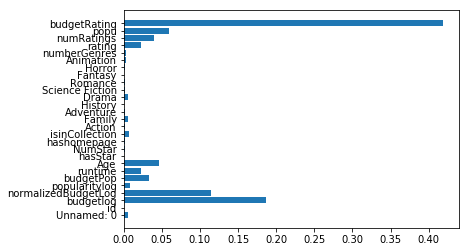

In [54]:
for i in range(0,len(X_train.columns)):
    print(X_train.columns[i], " - ",lgbmodel.feature_importances_[i] / lgbmodel.feature_importances_.sum())
importance = lgbmodel.feature_importances_ / lgbmodel.feature_importances_.sum()
plt.barh(np.arange(len(importance)), importance)
plt.yticks(np.arange(len(importance)), X_train.columns)
plt.show
#labels, ys = zip(*avg)
#xs = np.arange(len(labels)) 

#fig, ax = plt.subplots()
#ax.barh(xs, ys, align='center')
#plt.yticks(xs, labels)